In [1]:
import math
import numpy as np
import cv2, os
import pandas as pd
from numpy import linalg as LA
from PIL import Image
import matplotlib.pyplot as plt

# PCA 코드 살펴보기

## 1. DATA 불러오기 

In [2]:
S = []
Y = []

for name in os.listdir("../faces"):
    nameList = os.listdir("../faces/%s"%name)

    if len(nameList) <50 : 
        continue

    y = name.replace(".jpg","")

    count = 0
    for i in nameList:
        if count == 50 :
            break
        filePath = "../faces/%s/%s"%(name,i)

        # decoding path written by korean
        stream = open( filePath.encode("utf-8") , "rb")
        bytes = bytearray(stream.read())
        numpyArray = np.asarray(bytes, dtype=np.uint8)
        img = cv2.imdecode(numpyArray , cv2.IMREAD_UNCHANGED)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        imgArr = np.array(gray)
        temp = np.reshape(imgArr, (150*150))
        Y.append(y)
        S.append(temp)
        count += 1

S = np.array(S).T


## 2. 히스토그램 평활화

In [3]:
SS = np.zeros_like(S) 
for i in range(S.shape[1]):
    SS[:,i] = cv2.equalizeHist(S[:,i]).reshape(-1,)


In [4]:
S.shape[1]

350

In [5]:
SS[:,i].shape

(22500,)

In [6]:
SS.shape

(22500, 350)

## 3. 평균얼굴 구하기

In [7]:
m = np.mean(SS, axis=1) # 행기준으로 평균구함
m = m.reshape(-1, 1) 

In [8]:
m.shape

(22500, 1)

In [9]:
# m = np.mean(SS, axis=0) 
# m = m.shape 

In [10]:
# m = np.mean(SS, axis=1) 
# m = m.shape 

## 4. 차이 벡터 구하기

In [11]:
D = SS-m  #차이벡터를 모아둔 행렬 (22500,등록한사람*50)
D.shape

(22500, 350)

In [12]:
# 주의 : m = m.reshape(-1) 은 차이벡터 구할 때 오류 발생
# column vector 들을 복사해가면서 broadcasting 할 때는, 2-D array 로 만들어줘야 함
# m = np.mean(SS, axis=1)
# m = m.reshape(-1) 
# D = SS-m

## 5.주성분 구하기
## 5-1. D.T × D  의 eigenvalue/ eigenvector 구하기
* 공분산행렬: DxD.T (크기가 너무 커지므로-> D.TXD)


In [13]:
L = D.T @ D
w, v = LA.eig(L) # w:eignevalue v:eigenvector

In [14]:
L.shape

(350, 350)

In [15]:
w.shape # eigenvalue

(350,)

In [16]:
v.shape #eigenvector

(350, 350)

## 5-2. 0인 eigenvalue 제거
* 람다는 0이상이 나오기때문에 0은 아무런 정보가없으므로 0제거

In [17]:
zero_eigen = [i for i in range(len(w)) if abs(w[i]) <1e-4] # 0에 가까운것들을 뽑아서 zero_eigen에 모음 
j=0
for i in zero_eigen:
    w = np.delete(w, i-j, axis=0)
    v = np.delete(v, i-j, axis=1)
    j += 1 #중간에 뺴와도 index가 밀리지않게 해줌 

## 5-3. eigenvalue 내림차순 정렬 - eigenvalue에 해당하는 eigenvector 가져오기

In [18]:
# 실수만 나오는게 당연하지만 컴퓨터 오류를 생각해서 real 사용 
index = np.argsort(w.real)[::-1] # argsort: 인덱스를 가져옴 ex>1 5 4 3 6 이면 0 3 2 1 4
ww = w.real[index]
vv = v.real[:,index] 

## 5-4. 주축의 개수 정하기

In [19]:
eigenface_num= 20 # 주축의 개수 

In [20]:
ww = ww[:eigenface_num] # 행을 가져올땐 그냥 이렇게 쓰고 
vv = vv[:, :eigenface_num] # 열을 가져올땐 이렇게 써야함

In [42]:
vv.shape

(350, 20)

## 5-5. D × D.T 의 eigenvector 구하기

In [43]:
D.shape

(22500, 350)

In [21]:
u = D @ vv
u = u/(LA.norm(u, axis=0)) #unit vector로 만들어줌 

In [46]:
u.shape

(22500, 20)

## 5-6.  weight 값 찾기(내적) 

In [22]:
weight = u.T @ D  # weight = u @ D.T 

In [54]:
weight.shape

(20, 350)

In [53]:
weight[:, 0]

array([ -750.76898796, -4667.43757032,  -632.87868455, -2809.16665593,
         906.33328761,   428.70750467,  2015.05602595, -1551.17853466,
        2075.97947078,  -135.56065898,  1205.27487138,  1970.25932002,
        2514.68882162,  -594.44873914,  -420.72953964,   698.28465565,
         410.20903487,  -266.10669363,  2827.19981176,   793.48226003])

# 새로운 data가 왔을 때 코사인 유사도 계산?

In [24]:
FaceDB_info_df = pd.read_csv("../db/FaceDB_info.csv", index_col=0)
FaceDB_info_ar = np.array(FaceDB_info_df)
mean_face = FaceDB_info_ar[:, 0].reshape(-1,1)
eigenvector = FaceDB_info_ar[:, 1:]

In [25]:
mean_face.shape
eigenvector.shape

(22500, 20)

In [26]:
SID_weight = pd.read_csv("../db/FaceDB_SID.csv", index_col=0)
SID_index = list(SID_weight.index)
SID_weight = np.array(SID_weight)    

In [27]:
SID_weight.shape

(7, 20)

In [28]:
new_img = cv2.imread("../faces/jiho/26.jpg", cv2.IMREAD_GRAYSCALE).reshape(-1) #22500개의 벡터로 가져옴 reshape(-1)

In [29]:
new_img

array([ 14,  14,  12, ..., 195, 189, 185], dtype=uint8)

In [30]:
threshold = 0.5 #0.5보다 밑으로 내려가면 새로운 얼굴임

In [31]:
#새로운이미지도 똑같은 작업 실시
img = cv2.equalizeHist(new_img) - mean_face # 차이얼굴

img_weight = np.dot(img.T, eigenvector) #내적을 통해 weight 구하기
#dist1 = np.sqrt(np.sum(img_weight*img_weight))
dist1 = LA.norm(img_weight)

cosine_list = []
for i in range(SID_weight.shape[0]):
    #dist2 = np.sqrt(np.sum(SID_weight[i] * SID_weight[i]))
    dist2 = LA.norm(SID_weight[i])
    cosine_similiarity = np.dot(img_weight, SID_weight[i])/(dist1 * dist2)
    cosine_list.append(cosine_similiarity)


print(np.max(cosine_list))
if (np.max(cosine_list))<threshold:          
    print("None") 
else:
    SID = SID_index[np.argmax(cosine_list)]
    print(SID)

0.9070657855079128
jiho


In [32]:
img_weight.shape # 20개 숫자 확인 

(1, 20)

In [33]:
cosine_list

[array([-0.34570281]),
 array([0.58243338]),
 array([0.90706579]),
 array([0.04748505]),
 array([-0.45485652]),
 array([-0.64442507]),
 array([-0.33971086])]

In [34]:
new_img

array([ 14,  14,  12, ..., 195, 189, 185], dtype=uint8)

# mean_face? eigen_face?

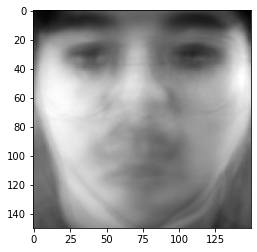

In [35]:
plt.imshow(mean_face.reshape(150, 150), cmap='gray')

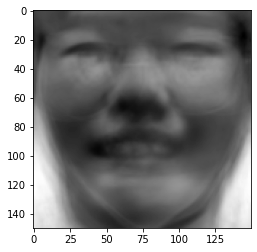

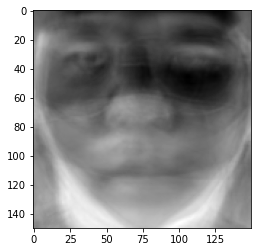

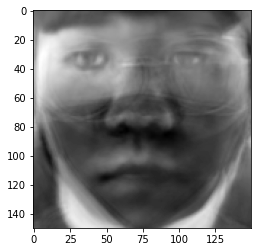

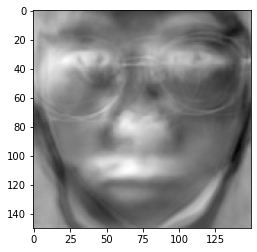

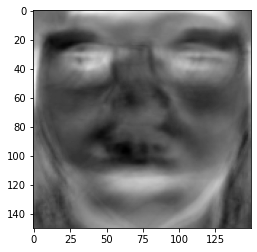

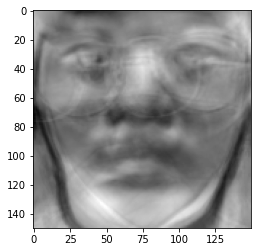

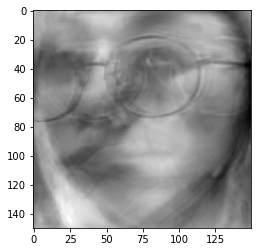

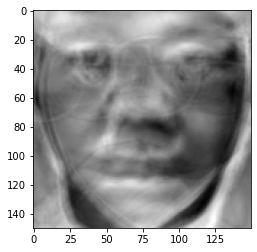

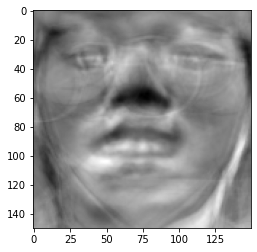

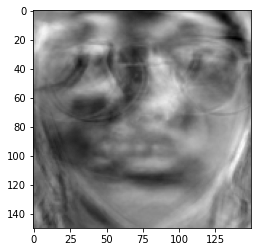

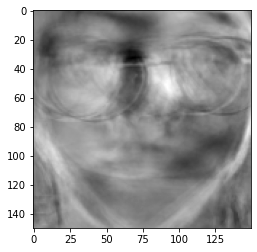

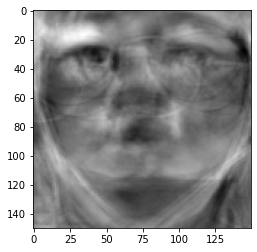

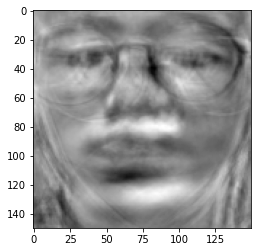

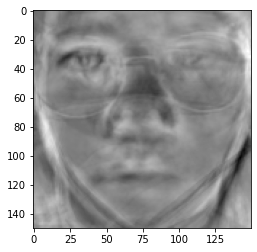

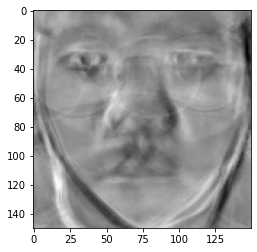

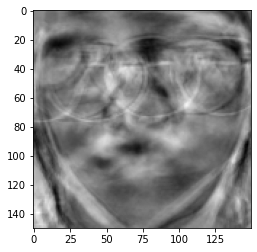

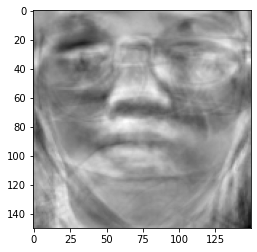

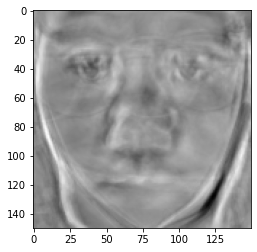

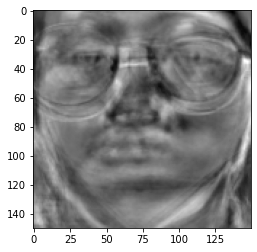

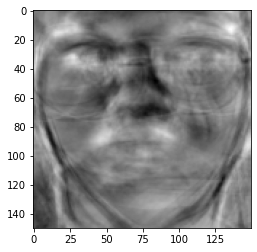

In [36]:
for i in range(eigenvector.shape[1]):
    plt.figure()
    plt.imshow(eigenvector[:,i].reshape(150, 150),  cmap='gray')

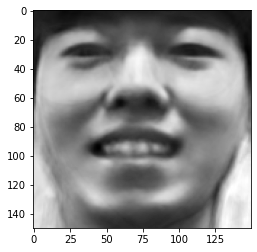

In [37]:
# 새로운 이미지일 때 이미지 재건
face1 = eigenvector@ img_weight.T + mean_face
plt.figure()
plt.imshow(face1.reshape(150, 150), cmap='gray')

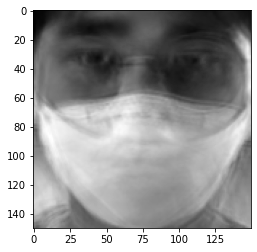

In [38]:
# weight 값 가지고 이미지 재건
face1 = eigenvector@ weight[:,199] + mean_face.reshape(-1)
plt.figure()
plt.imshow(face1.reshape(150, 150), cmap='gray')